[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/iterative_sense_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:iterative_sense_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# Iterative SENSE Reconstruction of 2D golden angle radial data
Here we use the IterativeSENSEReconstruction class to reconstruct images from ISMRMRD 2D radial data

In [2]:
# define zenodo URL of the example ismrmd data
zenodo_url = 'https://zenodo.org/records/10854057/files/'
fname = 'pulseq_radial_2D_402spokes_golden_angle_with_traj.h5'

In [3]:
# Download raw data
import tempfile

import requests

data_file = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.h5')
response = requests.get(zenodo_url + fname, timeout=30)
data_file.write(response.content)
data_file.flush()

### Image reconstruction
We use the IterativeSENSEReconstruction class to reconstruct images from 2D radial data.
IterativeSENSEReconstruction solves the following reconstruction problem:

Let's assume we have obtained the k-space data $y$ from an image $x$ with an acquisition model (Fourier transforms,
coil sensitivity maps...) $A$ then we can formulate the forward problem as:

$ y = Ax + n $

where $n$ describes complex Gaussian noise. The image $x$ can be obtained by minimizing the functional $F$

$ F(x) = ||W^{\frac{1}{2}}(Ax - y)||_2^2 $

where $W^\frac{1}{2}$ is the square root of the density compensation function (which corresponds to a diagonal
operator).

Setting the derivative of the functional $F$ to zero and rearranging yields

$ A^H W A x = A^H W y$

which is a linear system $Hx = b$ that needs to be solved for $x$.

In [4]:
import mrpro

##### Read-in the raw data

In [5]:
# Use the trajectory that is stored in the ISMRMRD file
trajectory = mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
# Load in the Data from the ISMRMRD file
kdata = mrpro.data.KData.from_file(data_file.name, trajectory)
kdata.header.recon_matrix.x = 256
kdata.header.recon_matrix.y = 256

##### Direct reconstruction for comparison

In [6]:
# For comparison we can carry out a direct reconstruction
direct_reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
img_direct = direct_reconstruction(kdata)

##### Iterative SENSE reconstruction

In [7]:
# We can use the direct reconstruction to obtain the coil maps.
iterative_sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    kdata, csm=direct_reconstruction.csm, n_iterations=4
)
img = iterative_sense_reconstruction(kdata)

### Behind the scenes

##### Set-up the density compensation operator $W$

In [8]:
# The density compensation operator is calculated based on the k-space locations of the acquired data.
dcf_operator = mrpro.data.DcfData.from_traj_voronoi(kdata.traj).as_operator()

##### Set-up the acquisition model $A$

In [9]:
# Define Fourier operator using the trajectory and header information in kdata
fourier_operator = mrpro.operators.FourierOp.from_kdata(kdata)

# Calculate coil maps
# Note that operators return a tuple of tensors, so we need to unpack it,
# even though there is only one tensor returned from adjoint operator.
img_coilwise = mrpro.data.IData.from_tensor_and_kheader(*fourier_operator.H(*dcf_operator(kdata.data)), kdata.header)
csm_operator = mrpro.data.CsmData.from_idata_walsh(img_coilwise).as_operator()

# Create the acquisition operator A
acquisition_operator = fourier_operator @ csm_operator

##### Calculate the right-hand-side of the linear system $b = A^H W y$

In [10]:
(right_hand_side,) = acquisition_operator.H(dcf_operator(kdata.data)[0])

##### Set-up the linear self-adjoint operator $H = A^H W A$

In [11]:
operator = acquisition_operator.H @ dcf_operator @ acquisition_operator

##### Run conjugate gradient

In [12]:
img_manual = mrpro.algorithms.optimizers.cg(
    operator, right_hand_side, initial_value=right_hand_side, max_iterations=4, tolerance=0.0
)

Text(0.5, 1.0, '"Manual" Iterative SENSE')

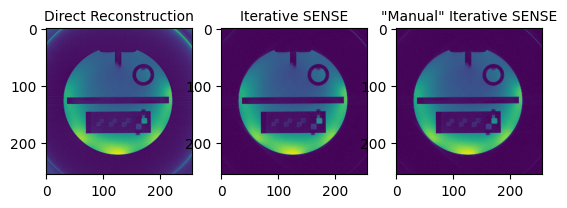

In [13]:
# Display the reconstructed image
import matplotlib.pyplot as plt
import torch

fig, ax = plt.subplots(1, 3, squeeze=False)
ax[0, 0].imshow(img_direct.rss()[0, 0, :, :])
ax[0, 0].set_title('Direct Reconstruction', fontsize=10)
ax[0, 1].imshow(img.rss()[0, 0, :, :])
ax[0, 1].set_title('Iterative SENSE', fontsize=10)
ax[0, 2].imshow(img_manual.abs()[0, 0, 0, :, :])
ax[0, 2].set_title('"Manual" Iterative SENSE', fontsize=10)

### Check for equal results
The two versions result should in the same image data.

In [14]:
# If the assert statement did not raise an exception, the results are equal.
assert torch.allclose(img.data, img_manual)